<b> IMPORTS

In [91]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from xgboost import XGBClassifier
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<b> LOAD & INSPECT DATA

In [92]:
matplotlib.__version__

'3.1.3'

In [93]:
df = pd.read_csv('data-final.csv', sep='\t')

In [94]:
df.head(1)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991


In [95]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015341 entries, 0 to 1015340
Columns: 110 entries, EXT1 to long_appx_lots_of_err
dtypes: float64(104), int64(2), object(4)
memory usage: 852.1+ MB


In [96]:
print('Number of rows:',df.shape[0])
print('Number of cols:',df.shape[1])

Number of rows: 1015341
Number of cols: 110


In [97]:
num_cols = df._get_numeric_data().columns
cat_cols = [col for col in df.columns if col not in num_cols]

In [98]:
print('Number of columns:',len(df.columns))
print('Numerical columns:',len(num_cols))
print('Categorical columns:',len(cat_cols))

Number of columns: 110
Numerical columns: 106
Categorical columns: 4


<b> CLEAN THE DATA

In [99]:
#IPC
"""
As per Kaggle dataset description:
The number of records from the user's IP address in the dataset. 
For max cleanliness, only use records where this value is 1. 
High values can be because of shared networks (e.g. entire universities) or multiple submissions
"""
df = df.loc[df['IPC']==1]

In [100]:
# Drop the unused data
drop_cols=list(df.columns[50:107])+list(df.columns[-2:])

In [101]:
df=df.drop((drop_cols), axis=1)

In [102]:
countries = df['country'].unique()
len(countries)

222

In [104]:
# A list of all EU countries
EU = ["AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "ES", "FI", "FR", "GB", "GR", "HR", "HU", "IE", "IT", "LT", "LU", "LV", "MT", "NL", "PL", "PT", "RO", "SE", "SI", "SK"]
len(EU)

28

In [105]:
# Check if all EU countries are in the data
intersection = set(EU).intersection(set(countries))
len(intersection)

28

In [106]:
# Limit the analysis to EU countries
df = df.loc[df['country'].isin(EU)]

In [107]:
df['country'].value_counts()[:5]

GB    49803
DE    12327
NL     7752
SE     7442
FR     5121
Name: country, dtype: int64

In [108]:
# This gives us percentage of responses from each country
df['country'].value_counts(normalize=True) * 100

GB    38.191020
DE     9.452858
NL     5.944557
SE     5.706836
FR     3.926997
IT     3.397109
ES     3.337295
PL     3.223803
IE     3.154787
FI     2.940071
DK     2.934703
RO     2.578122
BE     2.144856
GR     1.755301
PT     1.707757
AT     1.499942
HR     1.491507
CZ     1.214677
HU     1.021433
BG     0.871899
LT     0.719298
EE     0.661018
SK     0.620375
SI     0.565929
LV     0.361949
MT     0.246923
CY     0.184809
LU     0.144166
Name: country, dtype: float64

In [21]:
df.isna().mean()[:5]

EXT1    0.000798
EXT2    0.000798
EXT3    0.000798
EXT4    0.000798
EXT5    0.000798
dtype: float64

In [22]:
df = df.dropna()

In [23]:
df.isna().mean()[:5]

EXT1    0.0
EXT2    0.0
EXT3    0.0
EXT4    0.0
EXT5    0.0
dtype: float64

In [24]:
'''
Average characteristics

k-means clustering
logistic regression
random forests
feature importance/ tree plotting

lda- a lot of features, try last
'''


'\nAverage characteristics\n\nk-means clustering\nlogistic regression\nrandom forests\nfeature importance/ tree plotting\n\nlda- a lot of features, try last\n'

In [25]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0,GB
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0,GB
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0,GB
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,1.0,5.0,1.0,3.0,1.0,5.0,4.0,5.0,2.0,SE
8,2.0,2.0,3.0,3.0,4.0,2.0,2.0,2.0,4.0,4.0,...,1.0,5.0,1.0,4.0,1.0,5.0,2.0,5.0,5.0,GB


In [26]:
# Extraversion
EXT = list(df.columns[:10])
# Emotional Stability
EST = list(df.columns[10:20])
# Agreeableness
AGR = list(df.columns[20:30])
# Conscientiousness
CSN = list(df.columns[30:40])
# Openness
OPN = list(df.columns[40:50])

dimensions = [EXT,EST,AGR,CSN,OPN]
dimension_averages=["extraversion","emotional_stability",
       "agreeableness","conscientiousness","openness"]

In [27]:
for d in range(len(dimensions)):
    df[dimension_averages[d]] = df[dimensions[d]].mean(axis=1)

In [28]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN7,OPN8,OPN9,OPN10,country,extraversion,emotional_stability,agreeableness,conscientiousness,openness
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,5.0,3.0,4.0,5.0,GB,3.0,2.4,3.1,3.2,3.3
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,5.0,3.0,4.0,4.0,GB,2.9,2.6,2.8,2.8,3.1
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,4.0,4.0,3.0,3.0,GB,2.6,2.7,3.2,2.7,3.1
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,5.0,4.0,5.0,2.0,SE,3.0,2.2,2.8,2.9,3.2
8,2.0,2.0,3.0,3.0,4.0,2.0,2.0,2.0,4.0,4.0,...,5.0,2.0,5.0,5.0,GB,2.8,2.8,2.9,2.5,3.3


In [29]:
df[dimension_averages].describe()

,extraversion,emotional_stability,agreeableness,conscientiousness,openness
count,130301.000000,130301.000000,130301.000000,130301.000000,130301.000000
mean,2.985394,3.065468,3.105783,3.088718,3.307225
std,0.357523,0.650218,0.375960,0.407831,0.398023
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.800000,2.600000,2.900000,2.800000,3.100000
50%,3.000000,3.100000,3.100000,3.100000,3.300000
75%,3.200000,3.500000,3.300000,3.300000,3.600000
max,5.000000,5.000000,5.000000,5.000000,5.000000


In [30]:
corr=df[dimension_averages].corr()

Text(0.5, 1.0, 'Average characteristics of European citizens')

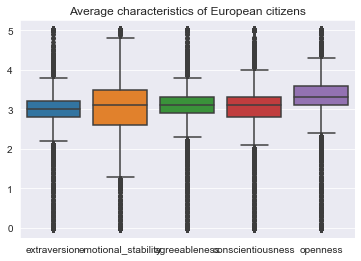

In [31]:
sns.set_style("darkgrid")
sns.boxplot(data=df[dimension_averages]);
sns.set(rc={'figure.figsize':(10,16)})
plt.title("Average characteristics of European citizens")

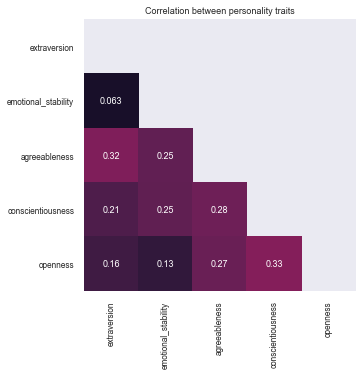

In [32]:
mask = np.triu(corr)
sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale=0.75)
sns.heatmap(df[dimension_averages].corr(),
            vmin=0,
            vmax=1,
            annot = True,
            square=True, 
            mask=mask,
            cbar=False)
plt.title('Correlation between personality traits')
plt.show()

In [33]:
# Subset df to only those with country GB, PL
gb = df.loc[df['country']=="GB"]
pl = df.loc[df['country']=="PL"]

In [34]:
# Limit the analysis to two countries and averages across 5 dimensions
pl = pl[pl.columns[-6:]]
gb = gb[gb.columns[-6:]]

In [35]:
dimension_averages

['extraversion',
 'emotional_stability',
 'agreeableness',
 'conscientiousness',
 'openness']

In [36]:
def transpose_table(df, col_list):
    """
    INPUT 
        df - a dataframe holding the col_list columns
        col_list- columns that we want to transpose into rows
        
    OUTPUT
        new_df- a transposed dataframe.
    """
    new_df = defaultdict(int)
    for i in col_list:
        new_df[i]=df[i].mean()
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.rename(columns={'index': 'personality', 0: 'average'}, inplace=True)
    new_df.set_index('personality', inplace=True)
    return new_df 

In [37]:
gb_avg = transpose_table(gb,dimension_averages)
pl_avg = transpose_table(pl,dimension_averages)
comp_df = pd.merge(gb_avg, pl_avg, left_index=True, right_index=True)
comp_df.columns = ['gb_avg', 'pl_avg']
comp_df['value_difference'] = comp_df['gb_avg'] - comp_df['pl_avg']
comp_df.style.bar(subset=['value_difference'], align='mid', color=['#d65f5f', '#5fba7d'])

,gb_avg,pl_avg,value_difference
personality,,,
extraversion,2.997948,2.928837,0.069112
emotional_stability,3.107214,3.160671,-0.053457
agreeableness,3.116576,3.087223,0.029352
conscientiousness,3.074450,3.122365,-0.047915
openness,3.304419,3.312515,-0.008096


In [38]:
df

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN7,OPN8,OPN9,OPN10,country,extraversion,emotional_stability,agreeableness,conscientiousness,openness
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,5.0,3.0,4.0,5.0,GB,3.0,2.4,3.1,3.2,3.3
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,5.0,3.0,4.0,4.0,GB,2.9,2.6,2.8,2.8,3.1
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,4.0,4.0,3.0,3.0,GB,2.6,2.7,3.2,2.7,3.1
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,5.0,4.0,5.0,2.0,SE,3.0,2.2,2.8,2.9,3.2
8,2.0,2.0,3.0,3.0,4.0,2.0,2.0,2.0,4.0,4.0,...,5.0,2.0,5.0,5.0,GB,2.8,2.8,2.9,2.5,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015304,2.0,5.0,3.0,4.0,3.0,4.0,3.0,4.0,5.0,5.0,...,3.0,3.0,4.0,2.0,IT,3.8,2.5,2.7,2.9,2.9
1015317,1.0,1.0,5.0,2.0,5.0,1.0,1.0,1.0,5.0,1.0,...,4.0,2.0,1.0,3.0,GB,2.3,3.0,3.0,2.8,2.2
1015326,3.0,1.0,3.0,3.0,4.0,1.0,5.0,3.0,3.0,2.0,...,5.0,5.0,5.0,5.0,GB,2.8,2.9,3.2,3.4,3.8
1015329,3.0,2.0,4.0,3.0,4.0,2.0,2.0,3.0,3.0,4.0,...,4.0,2.0,5.0,5.0,GB,3.0,2.6,3.4,2.7,3.3


In [39]:
df = df[df.columns[:-5]]
df

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0,GB
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0,GB
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0,GB
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,1.0,5.0,1.0,3.0,1.0,5.0,4.0,5.0,2.0,SE
8,2.0,2.0,3.0,3.0,4.0,2.0,2.0,2.0,4.0,4.0,...,1.0,5.0,1.0,4.0,1.0,5.0,2.0,5.0,5.0,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015304,2.0,5.0,3.0,4.0,3.0,4.0,3.0,4.0,5.0,5.0,...,2.0,3.0,2.0,3.0,4.0,3.0,3.0,4.0,2.0,IT
1015317,1.0,1.0,5.0,2.0,5.0,1.0,1.0,1.0,5.0,1.0,...,2.0,2.0,1.0,3.0,2.0,4.0,2.0,1.0,3.0,GB
1015326,3.0,1.0,3.0,3.0,4.0,1.0,5.0,3.0,3.0,2.0,...,1.0,5.0,1.0,5.0,1.0,5.0,5.0,5.0,5.0,GB
1015329,3.0,2.0,4.0,3.0,4.0,2.0,2.0,3.0,3.0,4.0,...,1.0,5.0,1.0,5.0,1.0,4.0,2.0,5.0,5.0,GB


In [40]:
df['is_gb'] = df['country'].apply(lambda x: 1 if x =='GB' else 0)

/Users/gajdulj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
df_model1 = df_model1.drop(columns='country')

In [55]:
X = df_model1[df_model1.columns[:-1]]
Y = df_model1[df_model1.columns[-1]]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [87]:
# fit model to training data
model = XGBClassifier(learning_rate=0.1, max_depth=6,
              min_child_weight=1,
              n_estimators=180, 
              objective='binary:logistic', 
                random_state=42, nthread=1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [88]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.73%


In [118]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=1,
    seed=42
)

In [120]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}

In [121]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 1,
    cv = 5,
    verbose=True
)

In [ ]:
grid_search.fit(X, Y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
grid_search.best_estimator_

In [110]:
from sklearn.metrics import roc_auc_score
auc=roc_auc_score(y_test, predictions)
print (auc)

0.640224609831134


In [117]:
thresholds=[0.39, 0.4,0.42, 0.43, 0.44, 0.45]
for t in thresholds:
    predictions=model.predict_proba(X_test)[:,1]>t
    print("AUC for threshold",t,":",
         roc_auc_score(y_test, predictions))
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

AUC for threshold 0.39 : 0.6663785163286001
Accuracy: 67.12%
AUC for threshold 0.4 : 0.6649190030035285
Accuracy: 67.37%
AUC for threshold 0.42 : 0.6625006136583531
Accuracy: 67.95%
AUC for threshold 0.43 : 0.6603791993536681
Accuracy: 68.15%
AUC for threshold 0.44 : 0.6574447091202001
Accuracy: 68.25%
AUC for threshold 0.45 : 0.6559468625021445
Accuracy: 68.47%
